# Song genre prediction
<b>Predict a song genre using its track features</b>

For this project, my research question is: <b>Is Spotify consistent in determining genres for every song in their libraries based on song features?</b><br>
<br>
Through its API, Spotify provided users with variety of track features, from tempo and key to whether the song is with lyrics or not and whether the song is suitable for dancing or not. These track features will be the X variables. Using these track features, I will predict the genre of the song. This also means, that genre is the Y variable.<br>
<br>
The unit of observation of this project is song. I will use 6 Spotify playlists from 6 different era: All Out 50s, All Out 60s, All Out 70s, All Out 80s, All Out 90s, and All Out 00s. Each playlist consist of minimum 100 songs.<br>
<br>
For this proejctI will use <a href="https://github.com/plamere/spotipy">Spotipy</a> library to get data from Spotify API. Let's get started!

## Data processing

In this section, I will firstly get the track IDs from all the playlist. Then, I from each track ID, will get the track features. From the Artist data, I will then get the possible genre of the song. Why possible genre? Because in Spotify, the genre is related to the artist, not the song. Therefore, each song might be tagged with multiple genre. These list of genre that is a categorical variables then will be transformed into dummy variables.
<hr>

Import necessary libraries for getting data from Spotify API and create files, then connect with my Spotify for Developer credentials

In [1]:
from __future__ import print_function
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from pprint import pprint
import json
import csv
import time
import sys
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id='eaa563769e874ccd85c8185f682ef625', client_secret='9d60c77a99e34791a1b126a06d43dcf6'))

Next, define the playlist IDs I'm going to work with. Since I hand-picked the playlist through Spotify Web Player, I was able to get the playlist ID through Spotify Web Player. Another way of doing this is to get a list of a user's playlist and search for the playlist IDs.<br>
<br>
In the below array, the playlist are sorted by oldest to newest (50s to 00s)

In [2]:
playlists = ['37i9dQZF1DWSV3Tk4GO2fq', '37i9dQZF1DXaKIA8E7WcJj', '37i9dQZF1DWTJ7xPn4vNaz', '37i9dQZF1DX4UtSsGT1Sbe', '37i9dQZF1DXbTxeAdrVG2l', '37i9dQZF1DX4o1oenSJRJd']

In the below code, we're getting the track IDs of every song on the above playlists and save them in a csv file, so that we can work with the data locally in the next process.

In [3]:
#source this
get_tracks = []

for list in playlists:
    offset = 0    
    
    while True:
        response = sp.playlist_items(list,
                                     offset=offset,
                                     fields='items.track.id,total',
                                     additional_types=['track'])

        if len(response['items']) == 0:
            break
        
        get_tracks.extend(response['items'])
        offset = offset + len(response['items'])
        

with open("tracks.json", "w") as outfile:
    json.dump(get_tracks, outfile)

In the below code, we take the tracks data stored locally and continue work with it. The data was saved as json file, we're going to transform it into a dataframe (df) for further working on it.

In [4]:
import pandas as pd

data = pd.read_json("tracks.json")
df = pd.json_normalize(data['track'])
df.head()

,id
0,3KzgdYUlqV6TOG7JCmx2Wg
1,06PdA0DLgF4BfAeUNZAbFG
2,11fNLqDB47gMKj7BHhR2Qr
3,72nqbbrKjhXmDdRXQGq115
4,1oDCK7PW72XEZ1pE5rh87A


In the next step, we take the track names, artist names and artist ids from the track id data we have.

In [5]:
#source this
tracks = df['id']
track_names = []
track_artists_name = []
track_artists_id = []

for track in tracks:
    urn = 'spotify:track:' + track
    track = sp.track(urn)
    track_name = track['name']
    track_artist_name = track['artists'][0]['name']
    track_artist_id = track['artists'][0]['id']
    track_names.append(track_name)
    track_artists_name.append(track_artist_name)
    track_artists_id.append(track_artist_id)
    
df['track names'] = track_names
df['artists name'] = track_artists_name
df['artists id'] = track_artists_id

df.head()


,id,track names,artists name,artists id
0,3KzgdYUlqV6TOG7JCmx2Wg,Beyond the Sea,Bobby Darin,0EodhzA6yW1bIdD5B4tcmJ
1,06PdA0DLgF4BfAeUNZAbFG,Blueberry Hill,Fats Domino,09C0xjtosNAIXP36wTnWxd
2,11fNLqDB47gMKj7BHhR2Qr,Wake up Little Susie,The Everly Brothers,4ACplpEqD6JIVgKrafauzs
3,72nqbbrKjhXmDdRXQGq115,All I Have to Do Is Dream,The Everly Brothers,4ACplpEqD6JIVgKrafauzs
4,1oDCK7PW72XEZ1pE5rh87A,Smile,Nat King Cole,7v4imS0moSyGdXyLgVTIV7


Source: https://developer.spotify.com/documentation/web-api/reference/object-model/#audio-features-object<br>
<br>
Next:<br>
From each track ID, will get the track features consisting of the following:
<ul>
    <li><b>Accousticness</b> (A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.)</li>
    <li><b>Danceability</b> (Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.)</li>
    <li><b>Duration_ms</b> (The duration of the track in milliseconds.)</li>
    <li><b>Energy</b> (Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.)</li>
    <li><b>Instrumentalness</b> (Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.)</li>
    <li><b>Key</b> (The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.)</li>
    <li><b>Liveness</b> (Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.)</li>
    <li><b>Loudness</b> (The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.)</li>
    <li><b>Mode</b> (Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.)</li>
    <li><b>Speechiness</b> (Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.)</li>
    <li><b>Time signature</b> (An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).)</li>
    <li><b>Valence</b> (A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).)</li>
</ul>

In [6]:
#source this
track_ids = df['id']
track_acousticness = []
track_danceability = []
track_duration_ms = []
track_energy = []
track_instrumentalness = []
track_key = []
track_liveness = []
track_loudness = []
track_mode = []
track_speechiness = []
track_time_signature = []
track_valence = []
                                            
for id in track_ids:
    features = sp.audio_features(id)
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    duration_ms = features[0]['duration_ms']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    key = features[0]['key']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    mode = features[0]['mode']
    speechiness = features[0]['speechiness']
    time_signature = features[0]['time_signature']
    valence = features[0]['valence']
    
    track_acousticness.append(acousticness)
    track_danceability.append(danceability)
    track_duration_ms.append(duration_ms)
    track_energy.append(energy)
    track_instrumentalness.append(instrumentalness)
    track_key.append(key)
    track_liveness.append(liveness)
    track_loudness.append(loudness)
    track_mode.append(mode)
    track_speechiness.append(speechiness)
    track_time_signature.append(time_signature)
    track_valence.append(valence)
    
df['track acousticness'] = track_acousticness
df['track danceability'] = track_danceability
df['track duration_ms'] = track_duration_ms
df['track energy'] = track_energy
df['track instrumentalness'] = track_instrumentalness
df['track key'] = track_key
df['track liveness'] = track_liveness
df['track loudness'] = track_loudness
df['track mode'] = track_mode
df['track speechiness'] = track_speechiness
df['track time_signature'] = track_time_signature
df['track valence'] = track_valence

df.head()

,id,track names,artists name,artists id,track acousticness,track danceability,track duration_ms,track energy,track instrumentalness,track key,track liveness,track loudness,track mode,track speechiness,track time_signature,track valence
0,3KzgdYUlqV6TOG7JCmx2Wg,Beyond the Sea,Bobby Darin,0EodhzA6yW1bIdD5B4tcmJ,0.723,0.521,172480,0.516,0.000000,2,0.2570,-7.456,0,0.0369,4,0.569
1,06PdA0DLgF4BfAeUNZAbFG,Blueberry Hill,Fats Domino,09C0xjtosNAIXP36wTnWxd,0.740,0.489,147880,0.499,0.000236,11,0.1560,-9.702,1,0.0271,3,0.829
2,11fNLqDB47gMKj7BHhR2Qr,Wake up Little Susie,The Everly Brothers,4ACplpEqD6JIVgKrafauzs,0.318,0.709,123520,0.620,0.000000,2,0.0426,-9.382,1,0.0340,4,0.936
3,72nqbbrKjhXmDdRXQGq115,All I Have to Do Is Dream,The Everly Brothers,4ACplpEqD6JIVgKrafauzs,0.783,0.542,141240,0.347,0.000000,4,0.1440,-14.011,1,0.0268,4,0.596
4,1oDCK7PW72XEZ1pE5rh87A,Smile,Nat King Cole,7v4imS0moSyGdXyLgVTIV7,0.862,0.226,173267,0.136,0.000008,5,0.3020,-19.203,0,0.0327,5,0.263


In the last step of gathering the data for this project, we'll get the genres from artist ids. The result might return a few genres per artist, therefore for this project, we use only the last genre with the assumption that it's the broadest genre. From then on, we filter it one more time to show only rock genre.

In [7]:
#source this
artists_id = df['artists id']
genres = []

for artist in artists_id:
    urn = 'spotify:artist:' + artist
    artist = sp.artist(urn)
    artist_genres = artist['genres']
    
    if len(artist_genres) != 0:
        broad_genre = artist_genres[-1] #only the last genre with the assumption that it's the broadest genre, also otherwise too many genre present.
    else:
        broad_genre = 'no genre'
    
    genres.append(broad_genre)
    
df['genres'] = genres
df.head()

,id,track names,artists name,artists id,track acousticness,track danceability,track duration_ms,track energy,track instrumentalness,track key,track liveness,track loudness,track mode,track speechiness,track time_signature,track valence,genres
0,3KzgdYUlqV6TOG7JCmx2Wg,Beyond the Sea,Bobby Darin,0EodhzA6yW1bIdD5B4tcmJ,0.723,0.521,172480,0.516,0.000000,2,0.2570,-7.456,0,0.0369,4,0.569,vocal jazz
1,06PdA0DLgF4BfAeUNZAbFG,Blueberry Hill,Fats Domino,09C0xjtosNAIXP36wTnWxd,0.740,0.489,147880,0.499,0.000236,11,0.1560,-9.702,1,0.0271,3,0.829,soul
2,11fNLqDB47gMKj7BHhR2Qr,Wake up Little Susie,The Everly Brothers,4ACplpEqD6JIVgKrafauzs,0.318,0.709,123520,0.620,0.000000,2,0.0426,-9.382,1,0.0340,4,0.936,sunshine pop
3,72nqbbrKjhXmDdRXQGq115,All I Have to Do Is Dream,The Everly Brothers,4ACplpEqD6JIVgKrafauzs,0.783,0.542,141240,0.347,0.000000,4,0.1440,-14.011,1,0.0268,4,0.596,sunshine pop
4,1oDCK7PW72XEZ1pE5rh87A,Smile,Nat King Cole,7v4imS0moSyGdXyLgVTIV7,0.862,0.226,173267,0.136,0.000008,5,0.3020,-19.203,0,0.0327,5,0.263,adult standards


In [8]:
df = df[df['genres'].str.contains('rock')]
df.head()

,id,track names,artists name,artists id,track acousticness,track danceability,track duration_ms,track energy,track instrumentalness,track key,track liveness,track loudness,track mode,track speechiness,track time_signature,track valence,genres
5,50RwvvEKX5Q7AZt8FTAwIF,That'll Be The Day,Buddy Holly,3wYyutjgII8LJVVOLrGI0D,0.467,0.536,150133,0.637,0.000000,2,0.0838,-7.774,1,0.0343,4,0.798,rockabilly
8,2FkCjtQ1lYsf71s2FAS8hE,The Great Pretender,The Platters,6KWcxMWVNVIYbdOQyJtsSy,0.943,0.425,160667,0.401,0.000003,7,0.0720,-9.427,1,0.0315,3,0.531,rockabilly
9,1eqGYJJr2z2GXK1i0hD3BC,Love Letters In The Sand - Single Version,Pat Boone,7fmKtIgmxqNEKjATioVNsu,0.811,0.571,134560,0.196,0.000000,3,0.1420,-13.216,1,0.0278,4,0.555,rockabilly
16,4chlGZQX5uPYpRLp3NezmX,Diana,Paul Anka,7ceUfdWq2t5nbatS6ollHh,0.341,0.570,138360,0.408,0.000000,7,0.5490,-9.932,1,0.0295,4,0.960,rock-and-roll
17,7ljPNANyoIDc7sL0PWaJlu,True Love Ways,Buddy Holly,3wYyutjgII8LJVVOLrGI0D,0.800,0.221,168707,0.124,0.103000,10,0.3160,-19.545,1,0.0346,4,0.276,rockabilly


As we can see below, now we have 389 songs in the dataframe. This number might change when the code run again and the API return more or less songs.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 5 to 846
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      390 non-null    object 
 1   track names             390 non-null    object 
 2   artists name            390 non-null    object 
 3   artists id              390 non-null    object 
 4   track acousticness      390 non-null    float64
 5   track danceability      390 non-null    float64
 6   track duration_ms       390 non-null    int64  
 7   track energy            390 non-null    float64
 8   track instrumentalness  390 non-null    float64
 9   track key               390 non-null    int64  
 10  track liveness          390 non-null    float64
 11  track loudness          390 non-null    float64
 12  track mode              390 non-null    int64  
 13  track speechiness       390 non-null    float64
 14  track time_signature    390 non-null    in

In the below value count, we can see that some of the rock sub genres are high in number, like soft rock with 146, but some of them have only 1 song in the dataframe, such as folk rock, classic garage rock, glam rock and australian rock.

In [10]:
df['genres'].value_counts()

soft rock              146
rockabilly              55
rock                    53
pop rock                44
yacht rock              41
rock-and-roll           23
symphonic rock          10
swamp rock               5
scottish rock            4
country rock             2
folk rock                2
roots rock               2
classic garage rock      1
australian rock          1
glam rock                1
Name: genres, dtype: int64

To make it clean for the prediction later, we'll choose rock sub genre that are similar in number: rockability, rock, pop rock and yacht rock.

In [11]:
include_genre = ['rockabilly', 'rock', 'pop rock', 'yacht rock']
df = df[df['genres'].isin(include_genre)]
df.head()

,id,track names,artists name,artists id,track acousticness,track danceability,track duration_ms,track energy,track instrumentalness,track key,track liveness,track loudness,track mode,track speechiness,track time_signature,track valence,genres
5,50RwvvEKX5Q7AZt8FTAwIF,That'll Be The Day,Buddy Holly,3wYyutjgII8LJVVOLrGI0D,0.467,0.536,150133,0.637,0.000000,2,0.0838,-7.774,1,0.0343,4,0.798,rockabilly
8,2FkCjtQ1lYsf71s2FAS8hE,The Great Pretender,The Platters,6KWcxMWVNVIYbdOQyJtsSy,0.943,0.425,160667,0.401,0.000003,7,0.0720,-9.427,1,0.0315,3,0.531,rockabilly
9,1eqGYJJr2z2GXK1i0hD3BC,Love Letters In The Sand - Single Version,Pat Boone,7fmKtIgmxqNEKjATioVNsu,0.811,0.571,134560,0.196,0.000000,3,0.1420,-13.216,1,0.0278,4,0.555,rockabilly
17,7ljPNANyoIDc7sL0PWaJlu,True Love Ways,Buddy Holly,3wYyutjgII8LJVVOLrGI0D,0.800,0.221,168707,0.124,0.103000,10,0.3160,-19.545,1,0.0346,4,0.276,rockabilly
21,5ueyLj6e6oVaTY0KQ6yLaA,All Shook Up,Elvis Presley,43ZHCT0cAZBISjO8DG9PnE,0.881,0.624,117080,0.468,0.000006,10,0.1440,-12.162,1,0.1320,4,0.952,rockabilly


Now, let's transform the rock genres into dummies for our prediction later and concatenate it to the dataframe.

In [12]:
dummies = df['genres'].str.get_dummies()
df = pd.concat([df, dummies], axis=1) 
df.head()

,id,track names,artists name,artists id,track acousticness,track danceability,track duration_ms,track energy,track instrumentalness,track key,...,track loudness,track mode,track speechiness,track time_signature,track valence,genres,pop rock,rock,rockabilly,yacht rock
5,50RwvvEKX5Q7AZt8FTAwIF,That'll Be The Day,Buddy Holly,3wYyutjgII8LJVVOLrGI0D,0.467,0.536,150133,0.637,0.000000,2,...,-7.774,1,0.0343,4,0.798,rockabilly,0,0,1,0
8,2FkCjtQ1lYsf71s2FAS8hE,The Great Pretender,The Platters,6KWcxMWVNVIYbdOQyJtsSy,0.943,0.425,160667,0.401,0.000003,7,...,-9.427,1,0.0315,3,0.531,rockabilly,0,0,1,0
9,1eqGYJJr2z2GXK1i0hD3BC,Love Letters In The Sand - Single Version,Pat Boone,7fmKtIgmxqNEKjATioVNsu,0.811,0.571,134560,0.196,0.000000,3,...,-13.216,1,0.0278,4,0.555,rockabilly,0,0,1,0
17,7ljPNANyoIDc7sL0PWaJlu,True Love Ways,Buddy Holly,3wYyutjgII8LJVVOLrGI0D,0.800,0.221,168707,0.124,0.103000,10,...,-19.545,1,0.0346,4,0.276,rockabilly,0,0,1,0
21,5ueyLj6e6oVaTY0KQ6yLaA,All Shook Up,Elvis Presley,43ZHCT0cAZBISjO8DG9PnE,0.881,0.624,117080,0.468,0.000006,10,...,-12.162,1,0.1320,4,0.952,rockabilly,0,0,1,0


Our data is ready!
<hr>

## Feature engineering

Feature engineering: explain which transformations you have made to make your variables more informative (e.g., calculating number of days from a starting date)
For the above dataset, not a lot of transformation happens to the data. We did have to undergo a few steps to actually get the genre: Track id > artist id > genre, while the track feature is relatively easy: Track id > Feature track. We do filter out the the subgenre from more than 260 to eventually be 4 that we're using for the prediction. These genre, which is a categorical data, are later on transformed into dummy or indicator variables.
<hr>

## Descriptive analysis

Now, we're going to look at most strongly correlating variables. We are going to remove some columns that currently is not usefull to see correlations between the track features.

In [13]:
# corr = df.drop(columns=['id', 'track names', 'artists name', 'artists id', 'genres', 'pop rock', 'rock', 'rockabilly', 'yacht rock'])
# corr = corr.corr()
# corr
corr = df.corr()
corr

,track acousticness,track danceability,track duration_ms,track energy,track instrumentalness,track key,track liveness,track loudness,track mode,track speechiness,track time_signature,track valence,pop rock,rock,rockabilly,yacht rock
track acousticness,1.000000,-0.189626,-0.455737,-0.609682,0.047387,-0.024257,0.020344,-0.444894,0.165373,0.055666,-0.149300,-0.049780,-0.231081,-0.181542,0.528206,-0.147820
track danceability,-0.189626,1.000000,-0.069125,0.163547,0.010424,-0.045089,-0.100180,0.089085,-0.104464,0.104989,0.230131,0.475820,0.215685,-0.247922,-0.031777,0.084371
track duration_ms,-0.455737,-0.069125,1.000000,0.079215,0.046154,-0.042571,-0.125827,0.100152,0.003535,-0.321069,-0.063499,-0.357958,0.196055,0.332405,-0.681611,0.188424
track energy,-0.609682,0.163547,0.079215,1.000000,-0.089826,-0.109522,0.180467,0.773155,-0.068542,0.171600,0.215377,0.355374,0.220836,0.132614,-0.221239,-0.127050
track instrumentalness,0.047387,0.010424,0.046154,-0.089826,1.000000,0.099258,0.119155,-0.155814,-0.177494,-0.025534,0.045384,-0.079213,-0.060715,0.091382,-0.081766,0.052797
track key,-0.024257,-0.045089,-0.042571,-0.109522,0.099258,1.000000,-0.001719,-0.144299,-0.136558,0.071998,-0.041709,-0.038172,0.010068,-0.101105,0.067425,0.025585
track liveness,0.020344,-0.100180,-0.125827,0.180467,0.119155,-0.001719,1.000000,0.106858,0.020711,0.017892,-0.000353,0.097210,-0.106557,0.131165,0.122112,-0.168591
track loudness,-0.444894,0.089085,0.100152,0.773155,-0.155814,-0.144299,0.106858,1.000000,0.048752,0.022606,0.136803,0.052527,0.327803,0.154769,-0.211653,-0.271516
track mode,0.165373,-0.104464,0.003535,-0.068542,-0.177494,-0.136558,0.020711,0.048752,1.000000,-0.020066,-0.078238,-0.103181,-0.065674,0.114274,0.089155,-0.155722
track speechiness,0.055666,0.104989,-0.321069,0.171600,-0.025534,0.071998,0.017892,0.022606,-0.020066,1.000000,0.011705,0.235516,-0.139678,-0.046942,0.259459,-0.091853


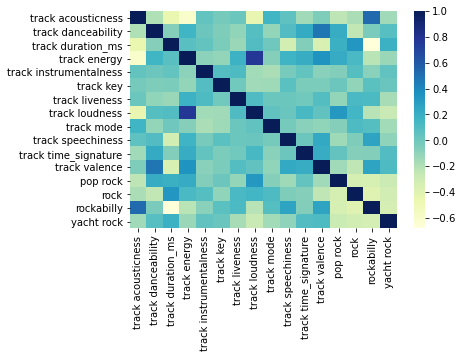

In [14]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="YlGnBu")
plt.show()

From the above heatmap, let's take a look at the track features correlation. We can see that the correlation between track energy and track loudness are highest. Then the track valence and danceability, followed by track valence and energy. Let's see their relation in the below graphs!<br>
<br>
Let's start with the variables that are high in correlation but not the highest: track valence and track danceability.

Text(0.5, 1.0, 'Track Danceability per Genres')

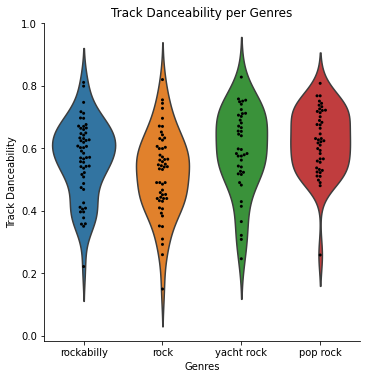

In [15]:
g = sns.catplot(x="genres", y="track danceability", kind="violin", inner=None, data=df)
sns.swarmplot(x="genres", y="track danceability", color="k", size=3, data=df, ax=g.ax)
plt.xlabel('Genres') 
plt.ylabel('Track Danceability')
plt.title('Track Danceability per Genres')

The above graph shows us that rockabilly danceability is mostly around 0.6 although ranging from around 0.1 to 0.95. Then, rock danceability is mostly around 0.55 and ranging from 0.05 to 1.0. Yacht rock is mostly around 0.5 to 0.7 and ranging from 0.1 to 0.95. Lastly, pop rock is mostly around 0.55 to 0.75 and ranging from 0.1 to 0.9.

Text(0.5, 1.0, 'Track Valence per Genres')

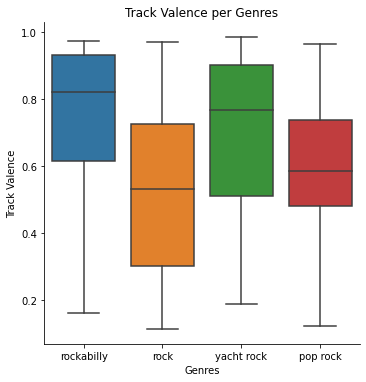

In [16]:
sns.catplot(x="genres", y="track valence", kind="box", data=df)
plt.xlabel('Genres') 
plt.ylabel('Track Valence')
plt.title('Track Valence per Genres')

The above graph shows us that rockabilly valence is ranging from around 0.55 to 0.9. Then, rock valence is ranging from 0.3 to 0.8. Yacht rock is ranging from 0.55 to 0.85. Lastly, pop rock is ranging from 0.5 to 0.75.

Now, let's take a look at the variables with the highest correlation: track energy and track loudness.

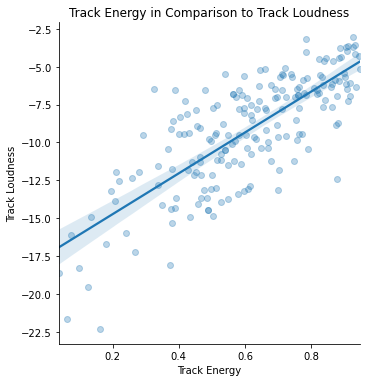

In [17]:
sns.lmplot(x='track energy', y='track loudness', fit_reg=True, data=df, scatter_kws={'alpha':0.3})
plt.xlabel('Track Energy') 
plt.ylabel('Track Loudness')
plt.title('Track Energy in Comparison to Track Loudness')
plt.show()

The above graph shows the track energy on the x axis and track loudness on the y axis. In this graph, we can analyze better the relationship between the two variables. The track energy that are low or from 0 to 0.4 have their track loudness until around -16.5 decibels. The track energy that are higher or more than 0.5, have their track loudness ranged from -15.5 to -2.5 decibels. The graph shows relatively linear distribution of dots, meaning that the track energy have linear relation to track loudness. The higher the track energy, the higher the track loudness.

Would the correlation still as strong when the genre is split into the sub genre? Let's quickly take a look at the below table that shows the mode (value that appears most often in a set of data values) of each track features.

In [18]:
df_mode = df.groupby(['genres']).agg(lambda x:x.value_counts().index[0])
df_mode = df_mode.drop(columns=['id', 'track names', 'artists name', 'artists id', 'pop rock', 'rock', 'rockabilly', 'yacht rock'])
df_mode

,track acousticness,track danceability,track duration_ms,track energy,track instrumentalness,track key,track liveness,track loudness,track mode,track speechiness,track time_signature,track valence
genres,,,,,,,,,,,,
pop rock,0.559,0.566,310333,0.786,0.0,9,0.106,-5.453,1,0.0355,4,0.455
rock,0.713,0.439,163373,0.488,0.0,0,0.103,-6.887,1,0.0421,4,0.660
rockabilly,0.856,0.602,134560,0.618,0.0,9,0.119,-6.826,1,0.0367,4,0.667
yacht rock,0.382,0.583,232240,0.549,0.0,7,0.128,-9.484,1,0.0335,4,0.823


If we visualize the data per genre like the above table, we can see that the linear approach for track loudness and track energy is no longer the case. However, we need to put in mind that the table above is just mode of everything per sub genre. It might be a different case if we include all the data.<br>
<br>
The above table also shows some interesting numbers that might influence the prediction later on as explained below:<br>
<br>
<u>The same numbers are shown on these columns, therefore probably won't influence the prediction as much:</u><br>
track instrumentalness, track mode, track time_signature<br>
<br>
<u>These numbers are quite close to each other, therefore probably won't influence the prediction as much:</u><br>
track valence (except for rock), track speechiness, track liveness<br><br>
<u>These numbers are quite different and probably would influence the prediction more than the others:</u><br>
track acousticness, track danceability (except for rockabilly), track duration_ms, track energy, track key, track loudness
<hr>

## Predictive model

explain which analysis you have chosen and why. In which you build a relevant statistical model or train a machine learning algorithm.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Training the algorithm

We will use the track features as the X variables. The X variables will be used to predict the genre.<br>
<br>
In the below cell, we also separate the training and test data. This built-in function from sk-learn splits the data set randomly into a train set and a test set. The test_size is 0.3, so the data is split into 70% training data and 30% test data

In [28]:
X = df[['track acousticness', 'track danceability', 'track duration_ms', 'track energy', 'track instrumentalness', 'track key', 'track liveness', 'track loudness', 'track mode', 'track speechiness', 'track time_signature', 'track valence']]

y = df['genres']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train.head()

,track acousticness,track danceability,track duration_ms,track energy,track instrumentalness,track key,track liveness,track loudness,track mode,track speechiness,track time_signature,track valence
441,0.6520,0.540,253080,0.465,0.005440,7,0.1320,-11.259,1,0.0302,4,0.341
601,0.0746,0.559,244813,0.928,0.000056,5,0.6960,-3.040,1,0.0355,4,0.599
56,0.8060,0.665,124000,0.179,0.000000,7,0.1890,-16.727,1,0.0367,4,0.856
844,0.5640,0.689,243494,0.432,0.000000,11,0.0928,-9.394,1,0.0452,4,0.747
430,0.0603,0.655,291686,0.606,0.078900,7,0.0757,-10.385,1,0.0285,4,0.765


### K Neighbours Classifier

Explain here

In [29]:
from sklearn.neighbors import KNeighborsClassifier #the object class we need

knn = KNeighborsClassifier(n_neighbors=3) #create a KNN-classifier with 3 neighbors
knn = knn.fit(X_train, y_train) #this fits the k-nearest neigbor model with the train data

### Random Forest Classifier

Next, I chose to use random forest model. Why random forest? Random forests consist of multiple single trees each based on a random sample of the training data. They are typically more accurate than single decision trees.<br>
<br>
The below random forest model is a built-in function from sk-learn. RF uses randomness, so I need to set a random_state if we want the result to be stable for presentation purposes.
<br>
<br>
I've also set the number of trees (n_estimators) to 100. This will become the default number of trees in the future of the sklearn package, since current literature suggests using more trees than was used traditionally (10). Also, computing power has increased (more trees require more computing power).

In [30]:
rf = RandomForestClassifier(random_state=1, n_estimators=100)
rf = rf.fit(X_train, y_train)

## Evaluating the model

### K Neighbours Classifier

Explain here

In [31]:
knn.score(X_test, y_test) #calculate the fit on the *test* data

0.4827586206896552

Accuracy is 48%. Change below<br>
<br>
An easy comparison is to compare with the best baseline guess: always guess "Not Survived". That would give us 424 / (424 + 290) = 59.4% (see *value_counts* above). So the model is a lot better than the baseline guess. Let's create a confusion matrix to evaluate precision and recall.

In [32]:
from sklearn.metrics import classification_report

for i in range(1,11):
    knn_new = KNeighborsClassifier(n_neighbors = i) #make a new kNN model with i (1-10) neighbors
    knn_new = knn_new.fit(X_train, y_train) #fit new model on train data
    y_test_pred_new = knn_new.predict(X_test) #predict using new model, with test data
    print(f"With {i} neighbors the result is:")
    print(classification_report(y_test, y_test_pred_new)) #use a built-in function to print out accuracy, precision and recall


With 1 neighbors the result is:
              precision    recall  f1-score   support

    pop rock       0.35      0.60      0.44        10
        rock       0.38      0.26      0.31        19
  rockabilly       0.73      0.80      0.76        20
  yacht rock       0.00      0.00      0.00         9

    accuracy                           0.47        58
   macro avg       0.37      0.42      0.38        58
weighted avg       0.44      0.47      0.44        58

With 2 neighbors the result is:
              precision    recall  f1-score   support

    pop rock       0.29      0.60      0.39        10
        rock       0.41      0.37      0.39        19
  rockabilly       0.83      0.75      0.79        20
  yacht rock       0.00      0.00      0.00         9

    accuracy                           0.48        58
   macro avg       0.38      0.43      0.39        58
weighted avg       0.47      0.48      0.47        58

With 3 neighbors the result is:
              precision    recall 

### Random Forest Classifier

Let's evaluate the model using our standard approach for a *classification* problem: making a confusion matrix and calculating accuracy, precision and recall.

The confusion matrix uses the *sorted* labels, so 0 comes first, 1 second.

In [33]:
y_test_pred = rf.predict(X_test) #the predicted values
cm = confusion_matrix(y_test, y_test_pred) #creates a "confusion matrix"
cm

array([[ 5,  3,  1,  1],
       [ 6,  8,  3,  2],
       [ 1,  0, 19,  0],
       [ 0,  0,  1,  8]])

In [34]:
y_pred = rf.predict(X_test) #the predicted values
conf_matrix = confusion_matrix(y_test, y_pred) #creates a "confusion matrix"
conf_matrix = pd.DataFrame(cm, index=['Female (actual)', 'Male (actual)'], columns = ['Female (predicted)', 'Male (predicted)']) 
conf_matrix

ValueError: Shape of passed values is (4, 4), indices imply (2, 2)

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    pop rock       0.42      0.50      0.45        10
        rock       0.73      0.42      0.53        19
  rockabilly       0.79      0.95      0.86        20
  yacht rock       0.73      0.89      0.80         9

    accuracy                           0.69        58
   macro avg       0.67      0.69      0.66        58
weighted avg       0.70      0.69      0.68        58



The precision for both female and male voice is very good (very close to 1): only about 2% of the male voice turns out to be female and 4% female voice turns out to be male.<br>
<br>
The recall is also really hight. It misses only 2% of female voice and 3% of male voice.<br>
<br>
I would say that the above numbers are pretty concrete prediction looking that only 2-4% of prediction were missed.

Evaluation: evaluate the model: numerically, qualitatively and in terms of practical value.<br>
References (optional): any literature referenced in APA style. Code snippets need not be referenced, but see Use of sources and plagiarism below.